In [2]:
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# https://www.youtube.com/watch?v=QIUxPv5PJOY

def format_data(df,start, end):
    training_data = df[start:end].drop('Date', axis = 1)
    return(training_data)
        
def create_xy_scaled(df, samples):
    
    dataset = df.values
    scaler = MinMaxScaler(feature_range = (0,1))
    scaled_data = scaler.fit_transform(dataset)
    data = scaled_data
    x = []
    y = []

    for i in range(samples, len(df)):
        x.append(data[i-samples:i])
        y.append(data[i])
        
    return(np.array(x), np.array(y), scaler)

#returns list of RSI values over n periods
def RSI(df, n):
    L = len(df)
    up = [0]*L
    down = [0]*L
    
    for i in range(1,L):
        if df['Close'][i-1] <= df['Close'][i]:
            up[i] = df['Close'][i] - df['Close'][i-1]
        if df['Close'][i-1] > df['Close'][i]:
            down[i] = abs(df['Close'][i] - df['Close'][i-1])

    avg_up= [0]*L
    avg_down = [0]*L
    
    avg_up[n] = np.mean(up[1:n+1])
    avg_down[n] = np.mean(down[1:n+1])
    
    for i in range(n+1,L):
        avg_up[i] = (avg_up[i-1]*(n-1)+up[i])/n
        avg_down[i] = (avg_down[i-1]*(n-1)+down[i])/n
    
    #return(avg_up,avg_down)
    RSI = [0]*L
    for i in range(n,L):
        RSI[i]= 100 - 100/(1+ (avg_up[i-1]/avg_down[i]))
    
    return(RSI)


##SMA, returns list of simple moving average over n periods
def SMA(stock_df,n):
    A = [0]*len(stock_df)
    for i in range(len(stock_df)-n+1):
        A[i+n-1] = np.mean(list(stock_df['Close'][i:i+n]))
    return(A)

#EMA, returns list of exponential moving average over n periods
def EMA(stock_df,n):
    mult = 2/(n+1)
    A = [0]*len(stock_df)
    A[n-1] = SMA(stock_df,n)[n-1]
    for i in range(n-1,len(stock_df)-1):
        A[i+1] = A[i]+(stock_df['Close'][i]-A[i])*mult
    return(A)

def unscale(data, scaler):
    return(scaler.inverse_transform(data))

def rescale(data, scaler):
    return(scaler.transform(data))

def pred(x, model):
    return(model.predict(x))

def pred(x, model):
    x = x.reshape(1, x.shape[0], x.shape[1])
    return(model.predict(x))

def make_new_row(df_columns, values):
    new_row = {}
    for i in range(len(values)):
        new_row[df_columns[i]] = values[i]
    return(new_row)

In [4]:
df = pd.read_csv('dataset_QQQ_20140207_to_20181231.csv')
df.drop('Date', axis =1, inplace = True)
samples = 100


x = create_xy_scaled(df,samples)[0]
y = create_xy_scaled(df, samples)[1]
scale = create_xy_scaled(df,samples)[2]
x_train = x[:1000].copy()
y_train = y[:1000].copy()

x_test = x[1001:].copy()
y_test = y[1001:].copy()

In [421]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(x_train, y_train, batch_size = 1, epochs = 1)

Train on 1000 samples
1000/1000 [==============================] - 40s 40ms/sample - loss: 0.0083


In [5]:
hyparam ={'loss':'mean_squared_error',
         'opt':'Adam',
         'epochs': 10,
         'batch_size':8}

regressor = Sequential()

regressor.add(LSTM(units = 16, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 16, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 32, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 64, activation = 'relu',))
regressor.add(Dropout(0.4))

regressor.add(Dense(units=y_train.shape[1]))

regressor.compile(optimizer = hyparam['opt'], loss = hyparam['loss'])

regressor.fit(x_train, y_train, epochs = hyparam['epochs'], batch_size = hyparam['batch_size'])

Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 21s 21ms/sample - loss: 0.0624
Epoch 2/10
1000/1000 [==============================] - 17s 17ms/sample - loss: 0.0263
Epoch 3/10
1000/1000 [==============================] - 19s 19ms/sample - loss: 0.0195
Epoch 4/10
1000/1000 [==============================] - 19s 19ms/sample - loss: 0.0186
Epoch 5/10
1000/1000 [==============================] - 19s 19ms/sample - loss: 0.0174
Epoch 6/10
1000/1000 [==============================] - 19s 19ms/sample - loss: 0.0154
Epoch 7/10
1000/1000 [==============================] - 17s 17ms/sample - loss: 0.0157
Epoch 8/10
1000/1000 [==============================] - 17s 17ms/sample - loss: 0.0141
Epoch 9/10
1000/1000 [==============================] - 17s 17ms/sample - loss: 0.0139
Epoch 10/10
1000/1000 [==============================] - 17s 17ms/sample - loss: 0.0130


In [6]:
regressor.save('2020-06-25-2-regressor.model')

W0625 18:14:50.185205 26560 deprecation.py:506] From c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Close      9 RSI      12 EMA      26 EMA
0    107.599998   0.000000    0.000000    0.000000
1    108.059998   0.000000    0.000000    0.000000
2    108.650002   0.000000    0.000000    0.000000
3    109.059998   0.000000    0.000000    0.000000
4    110.540001   0.000000    0.000000    0.000000
..          ...        ...         ...         ...
145  117.764694  98.558646  115.200344  113.370650
146  118.215240  98.748715  115.594859  113.696134
147  118.665077  98.910963  115.997995  114.030883
148  119.118065  99.049410  116.408315  114.374157
149  119.569763  99.169079  116.825200  114.725557

[150 rows x 4 columns]

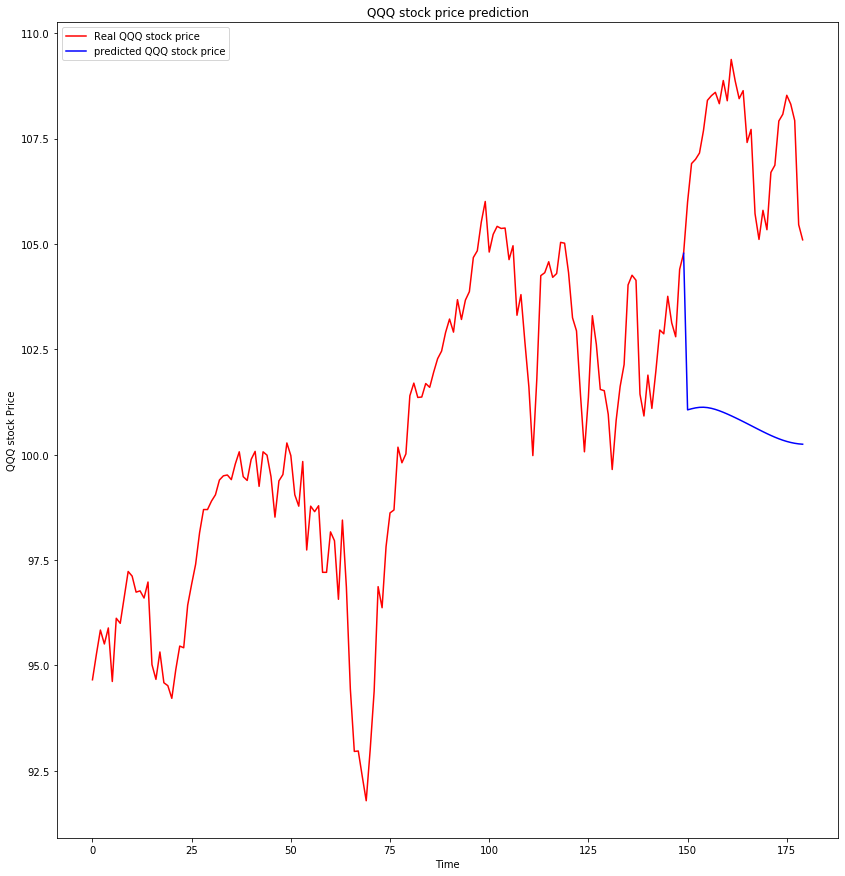

In [9]:
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
%matplotlib inline

# https://www.youtube.com/watch?v=QIUxPv5PJOY

def format_data(df,start, end):
    training_data = df[start:end].drop('Date', axis = 1)
    return(training_data)
        
def create_xy_scaled(df, samples):
    
    dataset = df.values
    scaler = MinMaxScaler(feature_range = (0,1))
    scaled_data = scaler.fit_transform(dataset)
    data = scaled_data
    x = []
    y = []

    for i in range(samples, len(df)):
        x.append(data[i-samples:i])
        y.append(data[i])
        
    return(np.array(x), np.array(y), scaler)

#returns list of RSI values over n periods
def RSI(df, n):
    L = len(df)
    up = [0]*L
    down = [0]*L
    
    for i in range(1,L):
        if df['Close'][i-1] <= df['Close'][i]:
            up[i] = df['Close'][i] - df['Close'][i-1]
        if df['Close'][i-1] > df['Close'][i]:
            down[i] = abs(df['Close'][i] - df['Close'][i-1])

    avg_up= [0]*L
    avg_down = [0]*L
    
    avg_up[n] = np.mean(up[1:n+1])
    avg_down[n] = np.mean(down[1:n+1])
    
    for i in range(n+1,L):
        avg_up[i] = (avg_up[i-1]*(n-1)+up[i])/n
        avg_down[i] = (avg_down[i-1]*(n-1)+down[i])/n
    
    #return(avg_up,avg_down)
    RSI = [0]*L
    for i in range(n,L):
        RSI[i]= 100 - 100/(1+ (avg_up[i-1]/avg_down[i]))
    
    return(RSI)


##SMA, returns list of simple moving average over n periods
def SMA(stock_df,n):
    A = [0]*len(stock_df)
    for i in range(len(stock_df)-n+1):
        A[i+n-1] = np.mean(list(stock_df['Close'][i:i+n]))
    return(A)

#EMA, returns list of exponential moving average over n periods
def EMA(stock_df,n):
    mult = 2/(n+1)
    A = [0]*len(stock_df)
    A[n-1] = SMA(stock_df,n)[n-1]
    for i in range(n-1,len(stock_df)-1):
        A[i+1] = A[i]+(stock_df['Close'][i]-A[i])*mult
    return(A)

def unscale(data, scaler):
    return(scaler.inverse_transform(data))

def rescale(data, scaler):
    return(scaler.transform(data))

def pred(x, model):
    return(model.predict(x))

def pred(x, model):
    x = x.reshape(1, x.shape[0], x.shape[1])
    return(model.predict(x))

def make_new_row(df_columns, values):
    new_row = {}
    for i in range(len(values)):
        new_row[df_columns[i]] = values[i]
    return(new_row)

model = tf.keras.models.load_model('2020-06-25-2-regressor.model')
QQQ = pd.read_csv('dataset_QQQ_20140207_to_20181231.csv')

QQQ.drop('Date', axis =1, inplace = True)
samples = 100
scale = create_xy_scaled(QQQ,samples)[2]


forecast = 30
start = 105
end = start + 150
df = QQQ[start:end]
df_test = QQQ[start:end+forecast].reset_index(drop = True)

for i in range(forecast):
    input = scale.transform(df[-samples:])
    new_row_values = unscale(pred(input[-samples:], model), scale)
    df = df.append(make_new_row(df.columns, new_row_values[0]), ignore_index = True)
    df[' 9 RSI'] = RSI(df, 9)
    df['12 EMA'] = EMA(df, 12)
    df['26 EMA'] = EMA(df, 26)
    

df_out = df[-forecast-1:].copy()

actual = df_test['Close']
pred = df_out['Close']

plt.figure(figsize = (14,15))
plt.plot(actual, color = 'red', label = 'Real QQQ stock price')
plt.plot(pred, color = 'blue', label = 'predicted QQQ stock price')
plt.title('QQQ stock price prediction')
plt.xlabel('Time')
plt.ylabel('QQQ stock Price')
plt.legend()
plt.show()